# Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np 
import os 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, log_loss, f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
from sklearn.utils import resample
import torch.nn.functional as F

Reading the file 

In [2]:
df = pd.read_csv('labelled_train_set.csv')
df.head()

,ID,News/Comment,Type
0,TRAIN_1,കേള്‍വി തകരാറുള്ള കുട്ടികള്‍ക്ക് നടത്തുന്ന സൗജ...,FALSE
1,TRAIN_2,ചന്ദ്രയാന് കേരള മുഖ്യമന്ത്രി പിണറായി വിജയൻ മാത...,FALSE
2,TRAIN_3,പിണറായി വിജയന്‍ സര്‍ക്കാര്‍ നിര്‍മിച്ച കേരളത്ത...,FALSE
3,TRAIN_4,മുഖ്യമന്ത്രിയുടെ ബിനാമി എന്ന് സ്വർണക്കടത്തു കേ...,FALSE
4,TRAIN_5,പിണറായി വിജയന്‍ ഇടപെട്ട് കേരളത്തില്‍ നിന്നുള്ള...,FALSE


Checking for missing values and dropping them

In [3]:
df['Type'].unique()

array(['FALSE', 'HALF TRUE', 'MOSTLY FALSE', 'PARTLY FALSE',
       'MOSTLY TRUE'], dtype=object)

In [4]:
for i in df['Type'].unique():
    print(i)

FALSE
HALF TRUE
MOSTLY FALSE
PARTLY FALSE
MOSTLY TRUE


In [5]:
for i in df['Type'].unique():
    print(f"Number of instances in {i} class :{df[df['Type'] == i]['Type'].value_counts()}")

Number of instances in FALSE class :Type
FALSE    1130
Name: count, dtype: int64
Number of instances in HALF TRUE class :Type
HALF TRUE    138
Name: count, dtype: int64
Number of instances in MOSTLY FALSE class :Type
MOSTLY FALSE    230
Name: count, dtype: int64
Number of instances in PARTLY FALSE class :Type
PARTLY FALSE    38
Name: count, dtype: int64
Number of instances in MOSTLY TRUE class :Type
MOSTLY TRUE    1
Name: count, dtype: int64


In [6]:
df = df.dropna(subset=['News/Comment'])
df.isna().sum()

ID              0
News/Comment    0
Type            0
dtype: int64

Upsampling the 'MOSTLY TRUE' Class because it had only one instance 

In [7]:
df_minority = df[df['Type'] == 'MOSTLY TRUE']
df_minority_upsampled = resample(df_minority, replace=True, n_samples=2, random_state=42)
df_upsampled = pd.concat([df[df['Type'] != 'MOSTLY TRUE'], df_minority_upsampled])
df_upsampled = df_upsampled.drop(columns=['ID'])

Encoding the labels

In [8]:
le = LabelEncoder()
df_upsampled['Type'] = le.fit_transform(df_upsampled['Type'])

Adding some features to better capture the meaning and context 

In [9]:
df_upsampled['length'] = df['News/Comment'].apply(len)
df_upsampled.head()

,News/Comment,Type,length
0,കേള്‍വി തകരാറുള്ള കുട്ടികള്‍ക്ക് നടത്തുന്ന സൗജ...,0,120
1,ചന്ദ്രയാന് കേരള മുഖ്യമന്ത്രി പിണറായി വിജയൻ മാത...,0,66
2,പിണറായി വിജയന്‍ സര്‍ക്കാര്‍ നിര്‍മിച്ച കേരളത്ത...,0,77
3,മുഖ്യമന്ത്രിയുടെ ബിനാമി എന്ന് സ്വർണക്കടത്തു കേ...,0,136
4,പിണറായി വിജയന്‍ ഇടപെട്ട് കേരളത്തില്‍ നിന്നുള്ള...,0,162


In [10]:
def count_unique_words(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words)

In [11]:
df_upsampled['unique_words'] = df_upsampled['News/Comment'].apply(count_unique_words)
df_upsampled.head()

,News/Comment,Type,length,unique_words
0,കേള്‍വി തകരാറുള്ള കുട്ടികള്‍ക്ക് നടത്തുന്ന സൗജ...,0,120,11
1,ചന്ദ്രയാന് കേരള മുഖ്യമന്ത്രി പിണറായി വിജയൻ മാത...,0,66,8
2,പിണറായി വിജയന്‍ സര്‍ക്കാര്‍ നിര്‍മിച്ച കേരളത്ത...,0,77,8
3,മുഖ്യമന്ത്രിയുടെ ബിനാമി എന്ന് സ്വർണക്കടത്തു കേ...,0,136,15
4,പിണറായി വിജയന്‍ ഇടപെട്ട് കേരളത്തില്‍ നിന്നുള്ള...,0,162,17


In [12]:
def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    if len(words) == 0:
        return 0
    
    ttr = len(unique_words)/len(words)
    return ttr 


In [13]:
df_upsampled['ttr_ratio'] = df_upsampled['News/Comment'].apply(calculate_ttr)

In [14]:
x = df_upsampled.drop(columns=['Type'])
y = df_upsampled['Type']

In [15]:
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [16]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,5),
    tokenizer=lambda x:re.findall(r'[^\W]+',x),
    max_features=100000
)
X_train_vec = vectorizer.fit_transform(x_train['News/Comment']).toarray()
X_test_vec = vectorizer.transform(x_test['News/Comment']).toarray()

c:\Users\anike\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,5),
    tokenizer=lambda x:re.findall(r'[^\W]+',x),
    max_features=100000
)
X_train_vec = vectorizer.fit_transform(x_train['News/Comment']).toarray()
X_test_vec = vectorizer.transform(x_test['News/Comment']).toarray()

In [18]:
additional_features_train = x_train[['length', 'unique_words', 'ttr_ratio']].values
additional_features_test = x_test[['length', 'unique_words', 'ttr_ratio']].values
X_train_combined = np.hstack([X_train_vec, additional_features_train])
X_test_combined = np.hstack([X_test_vec, additional_features_test])

In [19]:
x_train_tensor = torch.tensor(X_train_combined,dtype=torch.float32)
x_test_tensor = torch.tensor(X_test_combined,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values,dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values,dtype=torch.long)

In [20]:
train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [21]:


class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout1(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [22]:

input_dim = X_train_combined.shape[1]
output_dim = len(le.classes_)

In [23]:
model = Classifier(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
model.named_parameters


<bound method Module.named_parameters of Classifier(
  (fc1): Linear(in_features=93837, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)>

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
torch.cuda.get_device_name()

Using device: cuda


'NVIDIA GeForce GTX 1650 Ti'

In [26]:
model = model.to(device)
x_train_tensor = x_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [27]:
epochs = 100
training_losses = []
testing_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
    
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)  
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    testing_losses.append(test_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}')


Epoch 1/100, Training Loss: 1.1964, Testing Loss: 1.1711
Epoch 2/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 3/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 4/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 5/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 6/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 7/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 8/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 9/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 10/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 11/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 12/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 13/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 14/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 15/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 16/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 17/100, Training Loss: 1.1703, Testing Loss: 1.1711
Epoch 18/100, Training 

In [28]:
model.eval()
y_test_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:

        inputs = inputs.to(device)
 
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        y_test_pred.extend(preds.cpu().numpy())
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Macro F1 Score: {macro_f1:.4f}')
print(f'Accuracy Score: {accuracy:.4f}')

print(classification_report(y_test, y_test_pred, target_names=le.classes_, labels=[0, 1, 2, 3, 4]))


Macro F1 Score: 0.2550
Accuracy Score: 0.6299
              precision    recall  f1-score   support

       FALSE       0.76      0.83      0.79       226
   HALF TRUE       0.14      0.04      0.06        28
MOSTLY FALSE       0.20      0.09      0.12        46
 MOSTLY TRUE       0.00      0.00      0.00         0
PARTLY FALSE       0.03      0.12      0.05         8

   micro avg       0.63      0.63      0.63       308
   macro avg       0.23      0.22      0.20       308
weighted avg       0.60      0.63      0.61       308



c:\Users\anike\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anike\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anike\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anike\anaconda3\Lib\site-package

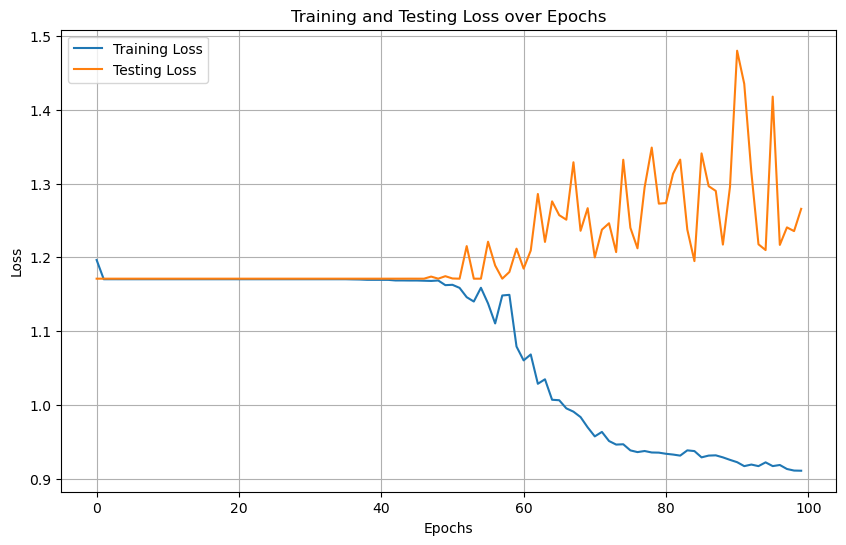

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), testing_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
utest = pd.read_csv('unlabelled_test1.csv')
test_vectorized = vectorizer.transform(utest['News/Comment']).toarray()
utest['length'] = utest['News/Comment'].apply(len)
utest['unique_words'] = utest['News/Comment'].apply(count_unique_words)
utest['ttr_ratio'] = utest['News/Comment'].apply(calculate_ttr)


In [31]:
add_utest = utest[['length', 'unique_words', 'ttr_ratio']].values
X_test_final = np.hstack([test_vectorized, add_utest])
final_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)


In [32]:
print("Vectorized test set's news/comment section has shape of : ",test_vectorized.shape)
print('Additional features added has shape : ',add_utest.shape)

Vectorized test set's news/comment section has shape of :  (132, 93834)
Additional features added has shape :  (132, 3)


In [33]:
final_tensor.shape

torch.Size([132, 93837])

In [34]:
model.eval()
with torch.no_grad():
    outputs = model(final_tensor)
    _, preds = torch.max(outputs, 1)
    y_test_pred = preds.cpu().numpy()

submission = pd.DataFrame({
    'ID': utest['ID'],
    'Predicted Type': y_test_pred
})

In [35]:
submission['Predicted Type'].value_counts()

Predicted Type
0    106
4     13
2      8
1      5
Name: count, dtype: int64

In [36]:
submission.to_csv('submission.csv', index=False)